#**Twitter Vaccine Sentiment Analysis**




In [ ]:
import pandas as pd
import numpy as np
import pickle
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True


#Load Dataset
---


>Option 1: Read Dataset from google drive


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
filename = '/content/gdrive/My Drive/Colab Notebooks/eclass_all_with_sentiment_v2.pkl'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


>Option 2: Upload Dataset

In [ ]:
from google.colab import files
file = files.upload()

filename = list(file.keys())[0]

###Get the Data

In [ ]:
dataset = pd.read_pickle(filename)

display(dataset.head(5))
print('Tweets before cleaning')
with pd.option_context('display.max_colwidth', 700):
  display(dataset.head(5)['text'])

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False,NEU
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,NEG
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,NEU
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False,NEU
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,NEG


Tweets before cleaning


0                                               Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF
1    While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm
2    #coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P
3    Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4
4         Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq
Name: text, dtype: object

#Data Cleaning


---



In [ ]:
import re
stop_en = stopwords.words("english")
def text_cleaner(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text) #remove @mentions
    text = text.lower()
    text = re.sub(r'RT[\s]+', '',text)         #remove "retweets"
    text = re.sub(r'http\S+', '', text)       #remove hyper links
    text = re.sub("'", "", text) # to avoid removing contractions in english
    text = re.sub("#[A-Za-z0-9_]+","", text)  #remove hashtags
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^a-z0-9]"," ", text)
    text = re.sub(r'[^A-Za-z ]', '', text)          #remove numbers
    text = re.sub(r'([A-Za-z])\1{2,}', r'\1', text) #From wooord -> word
    text = text.split()
    text = [w for w in text if not w in stop_en]
    text = " ".join(word for word in text)
    return text

dataset['text'] = dataset['text'].apply(text_cleaner)
print('Tweets after cleaning')
with pd.option_context('display.max_colwidth', 700):
  display(dataset.text.head(5))

Tweets after cleaning


0                             folks said daikon paste could treat cytokine storm
1     world wrong side history year hopefully biggest vaccination effort weve ev
2                                             russian vaccine created last years
3    facts immutable senator even youre ethically sturdy enough acknowledge born
4                                                           explain need vaccine
Name: text, dtype: object

###Print random tweets

In [ ]:

with pd.option_context('display.max_colwidth', 700):
  display(dataset.text.sample(n=10,replace=True))

170062                        uae approves indian vaccines covishield covaxin travel details
147239                                                self reporting covid adverse reactions
202979                          final approval children aged years expert opinion evaluation
165818                   year old man died days receiving vaccine vaccinated man good health
188724                         moderna vaccine side effects g reception still crap need talk
6676                                                         india ordered mn doses mn doses
120050                                                                   new policy proposal
3599      two days post dose yesterday experienced arm tenderness headache fatigue requiring
71709                             taiwan cases retreat record today may imported may may may
128315                                                      turkish doses amp locked hotel l
Name: text, dtype: object



#Data Analysis


---





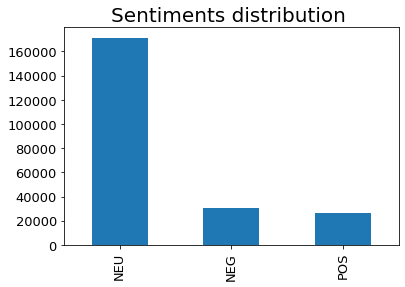

In [ ]:

sentiments = dataset['sentiment'].value_counts()
fig = sentiments.plot.bar(title='Sentiments distribution ', fontsize=13)
fig.axes.title.set_size(20)
#sentiments.plot.bar(title = 'Sentiments distribution',fontsize=12,figsize= (8,5));


##**Word Frequencies**


---

##All words




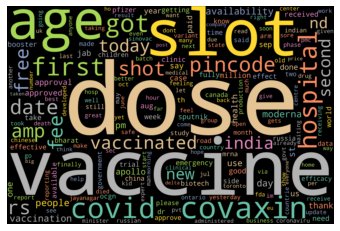

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

tweet_words = ' '.join([text for text in dataset['text']])
wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, 
                      background_color='black', colormap='Set2', 
                      collocations=False).generate(tweet_words)

plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

##Words per sentiment

Neutral


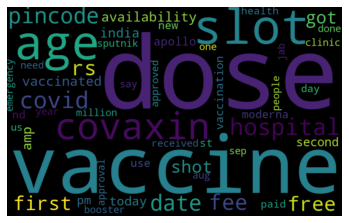

Positive


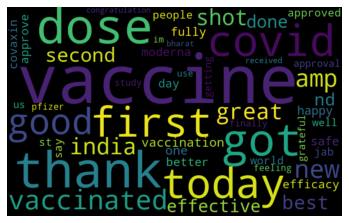

Negative


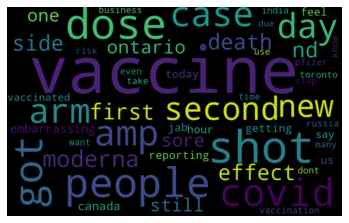

In [ ]:

sentiments = ['NEU', 'POS', 'NEG']
sentiment_dict = {'NEU':"Neutral",'POS':"Positive",'NEG':"Negative"}

for sentiment in sentiments:
  df_sentiment = dataset.loc[dataset['sentiment'] == sentiment]
  words = ' '.join([text for text in df_sentiment['text']])
  wordcloud = WordCloud(width = 800, height= 500, random_state=1, 
                        max_words=50,collocations=False).generate(words)
  print(sentiment_dict[sentiment])
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.axis('off')
  plt.show()

##Comparing sentiments between astrazeneca and pfizer/moderna


---



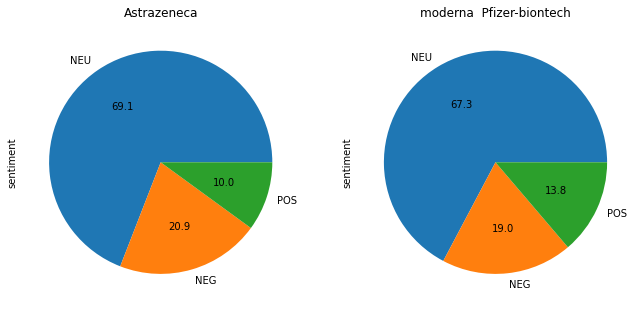

In [ ]:
df_astra = dataset[dataset['text'].str.contains("astrazeneca")] 
df_rest = dataset[dataset['text'].str.contains("pfizer|biontech|moderna")]  

astra_sentiments = df_astra['sentiment'].value_counts()    
rest_sentiments = df_rest['sentiment'].value_counts()         

figure, axes = plt.subplots(1, 2)
astra_sentiments.plot.pie(ax=axes[0],figsize=(11, 6),autopct="%.1f",title = 'Astrazeneca')
rest_sentiments.plot.pie(ax=axes[1],autopct="%.1f",title = 'moderna  Pfizer-biontech');

###include words in hashtags

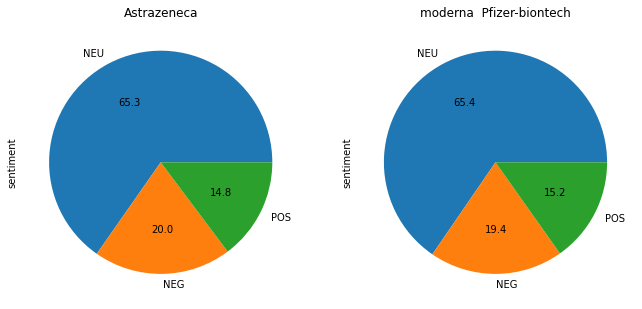

In [ ]:
#Include words in hashtags
df_astra = dataset[dataset['text'].str.contains("astrazeneca") |dataset['hashtags'].str.contains("astrazeneca") ] 
df_rest = dataset[dataset['text'].str.contains("pfizer|biontech|moderna") |dataset['hashtags'].str.contains("pfizer|biontech|moderna")]  

astra_sentiments = df_astra['sentiment'].value_counts()    
rest_sentiments = df_rest['sentiment'].value_counts()         

figure, axes = plt.subplots(1, 2)
astra_sentiments.plot.pie(ax=axes[0],figsize=(11, 6),autopct="%.1f",title = 'Astrazeneca')
rest_sentiments.plot.pie(ax=axes[1],figsize=(11, 6),autopct="%.1f",title = 'moderna  Pfizer-biontech');

##Tweets  per month


---

The majority of tweets produced between months 6/21 - 8/21. During that period of time covid cases with delta variant started to rise: 
https://www.cnbc.com/2021/07/23/covid-cases-are-rising-again-in-all-50-states-across-us-as-delta-variant-tightens-its-grip.html

https://www.bbc.com/news/world-57907681

https://www.aljazeera.com/news/2021/6/26/delta-covid-19-variant-forces-new-lockdowns-as-europe-eases-curbs

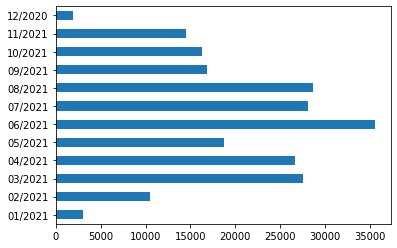

In [ ]:
dates = pd.to_datetime(dataset['date']).dt.strftime('%m/%Y')
dates.value_counts().sort_index().plot(kind='barh');


##Users with the most tweets

---



/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129417 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127757 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129417 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127757 missing from current font.
  font.set_text(s, 0, flags=flags)


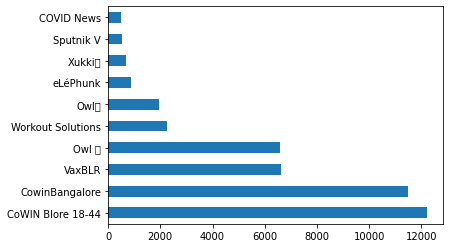

In [ ]:

top_users = dataset['user_name'].value_counts().index.tolist()
user_count = dataset['user_name'].value_counts()

user_count.head(10).plot(kind='barh');
#Error "Glyph 129417 missing .." is about emojis in nicknames 

Top two users have more than 10.000 tweets. And they are "promoting" a specific vaccine.


 CoWIN Blore 18-44


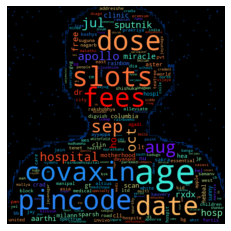


 CowinBangalore


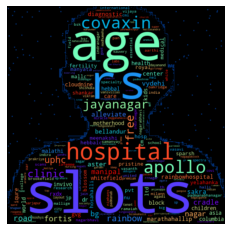

In [ ]:
from PIL import Image
from wordcloud import ImageColorGenerator
mask = np.array(Image.open('/content/gdrive/My Drive/Colab Notebooks/user.png'))

n = 2
df_topn_users = list()
for user in top_users[:n]:
  df_topn_users.append(dataset[dataset['user_name']==user])

#upload image for wordcloud
imagename = '/content/gdrive/My Drive/Colab Notebooks/user.jpg'
i = 0
for user in df_topn_users:
  user_words = ' '.join([text for text in user['text']])
  wordcloud = WordCloud( background_color='black',width = 3000, height = 2000,
                        mask = mask,contour_color='#023075',
                        contour_width=1,colormap='rainbow',
                        collocations=False).generate(user_words)
                        
  plt.figure()
  plt.imshow(wordcloud, interpolation = "bilinear")
  plt.axis('off')
  print('\n',top_users[i])
  i += 1
  plt.savefig("user.png", format="png")
  plt.show();

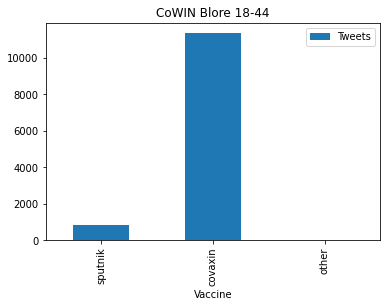

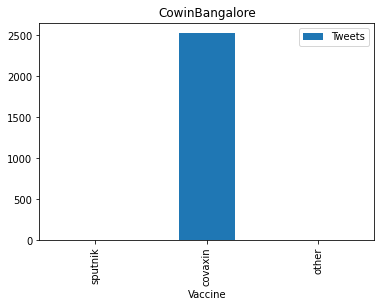

In [ ]:
for user in top_users[:n]:
  sputnik = len(df_topn_users[i][df_topn_users[i].text.str.contains("sputnik")])
  covaxin = len(df_topn_users[i][df_topn_users[i].text.str.contains("covaxin")] )
  other = len(df_topn_users[i][df_topn_users[i].text.str.contains("astrazeneca|pfizer|biontech|moderna")])
  vaccine_list = {'Vaccine':['sputnik', 'covaxin', 'other'], 
                'Tweets':[sputnik, covaxin, other]}
  pd.DataFrame(vaccine_list).plot.bar(x = 'Vaccine', y = 'Tweets',title = top_users[i])
  i += 1

#Bag of words


---
>Selecting dataset size


In [ ]:
#Work with the 10% of the dataset
n = 10
Nprecent = int(len(dataset)*(n/100))
print(Nprecent)
df = dataset.iloc[:Nprecent,:]
df2 = dataset.iloc[Nprecent:,:]

22820


In [ ]:
#work with the whole dataset
df = dataset

> Text Vectorization 

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split


vectorizer = CountVectorizer(max_df=1.0, min_df=1, max_features=1000)
bow_xtrain = vectorizer.fit_transform(df['text'])
xtrain_bow = bow_xtrain.toarray()
print(xtrain_bow.shape)
print(vectorizer.get_feature_names()[:20])

(22820, 1000)
['able', 'absolutely', 'access', 'according', 'aches', 'across', 'actually', 'additional', 'administer', 'administered', 'administering', 'administration', 'adverse', 'africa', 'african', 'afternoon', 'age', 'aged', 'agency', 'ago']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#Tf-idf

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=1, max_features=1000)
tfidf = tfidf_vectorizer.fit_transform(df['text'])
print(tfidf.shape)

(22820, 1000)


#Word embedings

>Tokenize tweet's text

In [ ]:
def tokenize_tweet(text):
  temp = text.split()
  temp = [nltk.word_tokenize(w)for w in temp ]
  return temp

df['tokenized'] = df['text'].apply(tokenize_tweet)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
import gensim
from gensim import models

model_w2v = gensim.models.Word2Vec(
  df['tokenized'] ,
  size=200, # desired no. of features/independent variables
  window=5, # context window size
  min_count=2,
  sg = 1, # 1 for skip-gram model
  hs = 0,
  negative = 10, # for negative sampling
  workers= 2, # no.of cores
  seed = 34)

model_w2v.train(df['tokenized'] , total_examples= len(df['tokenized'] ), epochs=20)
53